In [191]:
import numpy as np
import pandas as pd
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

import warnings
from influxdb_client.client.warnings import MissingPivotFunction
#warnings.simplefilter("ignore", MissingPivotFunction)


client = InfluxDBClient(url="http://192.168.0.112:8086", token='appdaemon-dev:opennow', org='-')
query_api = client.query_api()

def get_sensor_data(entity_id, column, start='-7d'):
    id_parts = entity_id.split('.')
    if len(id_parts) == 2:
        id_parts.append("value") # default for state field, otherwise attr
    q = f'''
    from(bucket: "homeassistant/autogen")
      |> range(start: {start})
      |> filter(fn: (r) => r.entity_id == "{id_parts[1]}" and r._field == "{id_parts[2]}" and r.domain == "{id_parts[0]}")
      |> pivot(rowKey:["_time"], columnKey: ["entity_id"], valueColumn: "_value")
      |> drop(columns: ["_measurement", "domain", "_start", "_stop"])
    '''
#     print(q)
    df = query_api.query_data_frame(q).drop(['result','table','_field'], axis=1)
    return df.rename(columns={id_parts[1]: column})

def compute_heat_index(temp_farenheit, relative_humidity):
    # relative humidity should be 0-100
    if temp_farenheit < 80: # seems like the formula below says it doesn't apply below 80ºF
        return temp_farenheit
    t = temp_farenheit
    rh = relative_humidity
    # https://www.weather.gov/media/epz/wxcalc/heatIndex.pdf
    return -42.379 + 2.04901523 * t + 10.14333127 * rh - 0.22475541 * t * rh - 6.83783e-3 * t * t - 5.481717e-2 * rh * rh + 1.22874e-3 * t * t * rh + 8.5282e-4 * t * rh * rh - 1.99e-6 * t * t * rh * rh

In [192]:
remote_sensor = 'bedroom'
remote_sensor = 'main_floor'
# remote_sensor = 'aysylu_office'

In [3]:
humidity = get_sensor_data(f"{remote_sensor}_sensor_bme280_humidity") # what we want to calibrate to
remote_temp = get_sensor_data(f"{remote_sensor}_sensor_bme280_temperature") # what we want to calibrate to
temp = get_sensor_data("thermostat_2", field="current_temperature") # thermostat's opinion
target_temp= get_sensor_data("thermostat_2", field="temperature") # thermostat's setting
mode = get_sensor_data("thermostat_2", field="hvac_action_str") # fan, heating, or cooling
hi = f"heat index of 80ºF at 90%rh = {compute_heat_index(80, 90)}"


# First, join all data together with the fill forward or something
# Add columns for feels like for the temperatures
## To find offset
# Filter for rows where the thermostat is not in "off" or "fan" mode
# Filter for rows where the thermostat thinks it hit its target
# Group by heat & cool modes to get the heat & cool fixed offsets
## To find speed of action (º/min or something)
# Using shift to find changes, filter for rows when the mode or target changed AND mode is heating or cooling
# Also filter for rows when the target temp was successfully hit
# Join those 2 frames together the initiated change & arrival time pairing
# Group by mode & compute averages (maybe confirm distributions are reasonable)

#print(temp)
#print(humidity)
base_times = pd.concat([x['_time'] for x in [temp, humidity, remote_temp, target_temp, mode]])
base_times = base_times.sort_values().drop_duplicates()
df = pd.merge_asof(base_times, temp, on='_time')
df = pd.merge_asof(df, target_temp, on='_time')
df = pd.merge_asof(df, humidity, on='_time')
df = pd.merge_asof(df, mode, on='_time')
df = pd.merge_asof(df, remote_temp, on='_time')
offset_df = df.query("hvac_action_str in ('heating', 'cooling') and current_temperature == temperature").copy()
offset_df['_time'] = offset_df['_time'].dt.tz_convert('America/New_York')
offset_df['delta'] = offset_df[f'{remote_sensor}_sensor_bme280_temperature'] - offset_df['current_temperature']
# #print(offset_df)
# #print(offset_df[['hvac_action_str', 'delta']].groupby('hvac_action_str').describe())
df = df.set_index('_time')


#print(change_events_df)

# Then, we'll have hot & cold offsets and hot & cold speeds
# These values may need to be additionally bucketed/broken down by time of day, difference between indoor/outdoor temp, or weather

TypeError: get_sensor_data() missing 1 required positional argument: 'column'

In [4]:
offset_df

NameError: name 'offset_df' is not defined

In [5]:
offset_df[['hvac_action_str', 'delta']].groupby('hvac_action_str').describe()

delta                                             
                 count      mean       std  min  25%  50%  75%  max
hvac_action_str                                                    
cooling           93.0 -1.503226  0.846791 -2.7 -2.3 -1.8 -0.7  0.0
heating          243.0  0.999177  0.538286 -0.7  0.7  1.1  1.3  2.2

In [85]:
df = df.drop([f'{remote_sensor}_sensor_bme280_temperature', f'{remote_sensor}_sensor_bme280_humidity'],axis=1)

In [86]:
pd.merge(df, change_df, left_index=True, right_index=True).dropna(subset=['hvac_action_str', 'action_before']).query("(hvac_action_str != action_before or temperature != target_before)")

,current_temperature,temperature,hvac_action_str,action_before,target_before
_time,,,,,
2022-10-09 08:53:57.534962+00:00,68.0,68.0,heating,fan,68.0
2022-10-09 08:58:57.614072+00:00,68.0,68.0,fan,heating,68.0
2022-10-09 09:33:57.785094+00:00,68.0,68.0,heating,fan,68.0
2022-10-09 09:43:57.703849+00:00,68.0,68.0,fan,heating,68.0
2022-10-09 10:03:57.678314+00:00,68.0,68.0,heating,fan,68.0
2022-10-09 11:23:57.846716+00:00,68.0,68.0,fan,heating,68.0
2022-10-09 11:48:57.771224+00:00,68.0,68.0,heating,fan,68.0
2022-10-09 11:53:57.887257+00:00,68.0,68.0,fan,heating,68.0
2022-10-10 02:13:59.118018+00:00,68.0,68.0,heating,fan,68.0


In [5]:
change_df = df[['hvac_action_str', 'temperature']].shift(1).rename(columns={'hvac_action_str': 'action_before', 'temperature': 'target_before'})
change_events_df = pd.merge(df, change_df, left_index=True, right_index=True).dropna(subset=['hvac_action_str', 'action_before']).query("(hvac_action_str != action_before or temperature != target_before) and hvac_action_str not in ['fan', 'off'] and current_temperature != temperature")

stable_df = df.query('current_temperature == temperature').drop(['current_temperature', 'temperature'],axis=1)
stable_df['stable_time'] = stable_df.index
change_events_df['temp_delta'] = change_events_df['temperature'] - change_events_df['current_temperature']
change_events_df = pd.merge_asof(change_events_df, stable_df, left_index=True, right_index=True, by='hvac_action_str', direction='forward').dropna(subset=['stable_time'])
change_events_df['time_delta'] = (change_events_df['stable_time'] - change_events_df.index).dt.total_seconds()
change_events_df['adapt_rate_degrees_per_hr'] = change_events_df['temp_delta'] / (change_events_df['time_delta'] / 3600.0)
change_events_df

NameError: name 'df' is not defined

In [6]:
"foo".startswith('f')

True

In [193]:
remote_temp_ent = 'sensor.main_floor_sensor_bme280_temperature'
thermostat_ent='climate.thermostat_2'
remote_temp = get_sensor_data(remote_temp_ent, column='remote_temp')
temp = get_sensor_data(thermostat_ent + ".current_temperature", column='current_temp')
target_temp = get_sensor_data(thermostat_ent + ".temperature", column='target_temp')
mode = get_sensor_data(thermostat_ent + ".state", column='hvac_action')
base_times = pd.concat([x['_time'] for x in [temp, remote_temp, target_temp, mode]])
base_times = base_times.sort_values().drop_duplicates()
df = pd.merge_asof(base_times, temp, on='_time')
df = pd.merge_asof(df, target_temp, on='_time')
df = pd.merge_asof(df, mode, on='_time')
df = pd.merge_asof(df, remote_temp, on='_time')
df
offset_df = df.query("hvac_action in ('heat', 'cool') and current_temp == target_temp").copy()
offset_df._time= offset_df._time.dt.tz_convert('America/New_York')
offset_df['delta'] = offset_df['remote_temp'] - offset_df['current_temp']
offset_df
result = offset_df[['hvac_action', 'delta']].groupby('hvac_action').describe()
result

delta                                             
              count      mean       std  min  25%  50%  75%  max
hvac_action                                                     
heat         1317.0  0.046621  0.866349 -1.7 -0.6  0.0  0.6  2.9

In [196]:
'cool' in Out[193].index

False

In [199]:
x = {'a': 'off'}
x = {'k': 1, 'v': 2, **x}
x = {**x, 'a': 1, 'b': 2}
x

{'a': 1, 'b': 2, 'k': 1, 'v': 2}

In [9]:
temp = get_sensor_data(thermostat_ent + ".current_temperature", column="current_temp")
target_temp = get_sensor_data(thermostat_ent + ".temperature", column="target_temp")
mode = get_sensor_data(thermostat_ent + ".state", column="hvac_mode")
base_times = pd.concat([x['_time'] for x in [temp, target_temp, mode]])
base_times = base_times.sort_values().drop_duplicates()
df = pd.merge_asof(base_times, temp, on='_time')
df = pd.merge_asof(df, target_temp, on='_time')
df = pd.merge_asof(df, mode, on='_time')
df['_time'] = df['_time'].dt.tz_convert('America/New_York')
df = df.set_index('_time')
change_df = df[['hvac_mode', 'target_temp']].shift(1).rename(columns={'hvac_mode': 'mode_before', 'target_temp': 'target_before'})
change_events_df = pd.merge(df, change_df, left_index=True, right_index=True).dropna(subset=['hvac_mode', 'mode_before'])
change_events_df = change_events_df.query("(hvac_mode != mode_before or target_temp != target_before) and hvac_mode not in ['fan', 'off'] and current_temp != target_temp")
change_events_df


stable_df = df.query('current_temp == target_temp').drop(['current_temp'],axis=1).rename(columns={'target_temp': 'stable_temp'})
stable_df['stable_time'] = stable_df.index
change_events_df['temp_delta'] = change_events_df['target_temp'] - change_events_df['current_temp']
change_events_df = pd.merge_asof(change_events_df, stable_df, left_index=True, right_index=True, by='hvac_mode', direction='forward').dropna(subset=['stable_time'])
change_events_df = change_events_df.query("(temp_delta > 0 and hvac_mode == 'heat') or (temp_delta < 0 and hvac_mode == 'cool')")
change_events_df['time_delta'] = (change_events_df['stable_time'] - change_events_df.index).dt.total_seconds()
change_events_df['adapt_rate_degrees_per_hr'] = change_events_df['temp_delta'] / (change_events_df['time_delta'] / 3600.0)
change_events_df



,current_temp,target_temp,hvac_mode,mode_before,target_before,temp_delta,stable_temp,stable_time,time_delta,adapt_rate_degrees_per_hr
_time,,,,,,,,,,
2022-10-11 06:19:02.623873-04:00,69.0,71.0,heat,heat,69.0,2.0,71.0,2022-10-11 06:22:03.769376-04:00,181.145503,39.747054
2022-10-13 20:45:35.470213-04:00,72.0,71.0,cool,cool,72.0,-1.0,70.0,2022-10-13 20:50:35.274542-04:00,299.804329,-12.007832
2022-10-13 20:45:39.855029-04:00,72.0,70.0,cool,cool,71.0,-2.0,70.0,2022-10-13 20:50:35.274542-04:00,295.419513,-24.372121
2022-10-13 21:38:30.718864-04:00,70.0,71.0,heat,cool,70.0,1.0,69.0,2022-10-13 21:45:35.955858-04:00,425.236994,8.465867
2022-10-16 22:52:02.276856-04:00,73.0,71.0,cool,cool,73.0,-2.0,71.0,2022-10-16 22:57:02.314867-04:00,300.038011,-23.996960


In [10]:
# struct encryption_block
# {
#     uint8_t key[16];
#     uint8_t plain_text[16];
#     uint8_t cipher_text[16];
# };

# bool ble_ll_resolv_rpa(const uint8_t *rpa, const uint8_t *irk) {
#     struct encryption_block ecb;

#     auto irk32 = (const uint32_t *)irk;
#     auto key32 = (uint32_t *)&ecb.key[0];
#     auto pt32 = (uint32_t *)&ecb.plain_text[0];

#     key32[0] = irk32[0];
#     key32[1] = irk32[1];
#     key32[2] = irk32[2];
#     key32[3] = irk32[3];

#     pt32[0] = 0;
#     pt32[1] = 0;
#     pt32[2] = 0;
#     pt32[3] = 0;

#     ecb.plain_text[15] = rpa[3];
#     ecb.plain_text[14] = rpa[4];
#     ecb.plain_text[13] = rpa[5];

#     auto err = bt_encrypt_be(ecb.key, ecb.plain_text, ecb.cipher_text);

#     if (ecb.cipher_text[15] != rpa[0] || ecb.cipher_text[14] != rpa[1] || ecb.cipher_text[13] != rpa[2]) return false;

#     // Serial.printf("RPA resolved %d %02x%02x%02x %02x%02x%02x\n", err, rpa[0], rpa[1], rpa[2], ecb.cipher_text[15], ecb.cipher_text[14], ecb.cipher_text[13]);

#     return true;
# }


In [11]:
from Crypto.Cipher import AES
key = b'\x0C\x95\x82\xB2\xC7\xD3\xBE\x4B\x8B\xE2\xE2\xC3\x3F\xFE\xFA\x8F' # 16 byte string
cipher = AES.new(key, AES.MODE_ECB)
msg = cipher.encrypt('ble key'+' '*9)
msg

b'\x0f\xa5\xfe\xa4\xa5\x97\xdf\xb3W\xdc\xdaJ\xe8Z\xc1\xa2'

In [12]:
addr_raw = """[NEW] Device 7F:77:61:56:DD:6F 7F-77-61-56-DD-6F
[NEW] Device E2:56:05:BB:48:B2 Tile
[NEW] Device DE:A9:58:4E:D1:78 Tile
[NEW] Device C4:7C:8D:6D:BC:FD Flower care
[NEW] Device C4:7C:8D:6D:BD:EE Flower care
[NEW] Device F4:25:AC:66:0D:A7 F4-25-AC-66-0D-A7
[NEW] Device E0:DC:F2:1A:90:30 Cue 9383"""
addrs= [b'\x50\x41\xF3\x1E\x02\xF4', b'\x54\x8D\x5A\x6A\xE4\x46']
for x in addr_raw.split('\n'):
    off = len("[NEW] Device ")
    l = len('E8:79:8A:5B:28:4B')
    ex = bytes.fromhex(x[off:off+l].replace(':',''))
    addrs.append(ex)
addrs

[b'PA\xf3\x1e\x02\xf4',
 b'T\x8dZj\xe4F',
 b'\x7fwaV\xddo',
 b'\xe2V\x05\xbbH\xb2',
 b'\xde\xa9XN\xd1x',
 b'\xc4|\x8dm\xbc\xfd',
 b'\xc4|\x8dm\xbd\xee',
 b'\xf4%\xacf\r\xa7',
 b'\xe0\xdc\xf2\x1a\x900']

In [13]:
#addrs = [bytes.fromhex(x.replace(':','')) for x in ['44:A1:DE:01:6E:FE', '0E:52:87:80:DF:94', '02:EB:02:F5:20:9C', 'F0:72:EA:75:B8:F9',
#                                                   'C0:28:8D:32:E3:8C', 'F0:72:EA:63:FB:89', ]]
for addr in addrs:
    pt = bytearray(b'\0' * 16)
    pt[15] = addr[2]
    pt[14] = addr[1]
    pt[13] = addr[0]
    msg = cipher.encrypt(bytes(pt))
    if msg[15] == addr[5] and msg[14] == addr[4] and msg[13] == addr[3]:
        print(f'found a match: {addr}')

found a match: b'PA\xf3\x1e\x02\xf4'
found a match: b'\x7fwaV\xddo'


In [14]:
df = pd.DataFrame(columns=['time', 'device', 'source', 'rssi'])
df = pd.concat([df,{'time': pd.datetime(2020,1,4), 'device': 'phoen', 'source':'bob', 'rssi':22}, ignore_index=True)
df = df.append({'time': pd.datetime(2020,1,4), 'device': 'phoen', 'source':'bob', 'rssi':22}, ignore_index=True)
df

SyntaxError: invalid syntax (<ipython-input-14-995b732cca60>, line 2)

In [206]:
from glob import glob
from sklearn.neighbors import KNeighborsClassifier
dfs = []
for x in glob('probe_captures_20221024/examples*.csv'):
    df = pd.read_csv(x, parse_dates=[0])
    dfs.append(df)
df = pd.concat(dfs)
base_station_names = list(df['source'].unique())
df = df.sort_values(by=['time']).query("not (tag == 'basement-david-only' and device in ['aysylu phone', 'aysylu watch'])")
df

,time,device,source,rssi,tag
0,2022-10-22 23:45:27.950126+00:00,david phone,living_room_blinds,-64,main-floor-dnd
1,2022-10-22 23:45:27.980039+00:00,aysylu phone,bedroom_blinds,-82,main-floor-dnd
2,2022-10-22 23:45:28.266548+00:00,david watch,living_room_blinds,-87,main-floor-dnd
3,2022-10-22 23:45:29.588189+00:00,aysylu watch,bedroom_blinds,-82,main-floor-dnd
4,2022-10-22 23:45:29.649957+00:00,aysylu phone,basement_pi,-73,main-floor-dnd
...,...,...,...,...,...
76,2022-10-24 22:06:15.923600+00:00,david watch,living_room_blinds,-70,basement-david-only
77,2022-10-24 22:06:16.219159+00:00,david watch,bedroom_blinds,-80,basement-david-only
79,2022-10-24 22:06:17.668692+00:00,david phone,basement_pi,-81,basement-david-only
82,2022-10-24 22:06:18.167759+00:00,david watch,bedroom_blinds,-79,basement-david-only


<IPython.core.display.Javascript object>


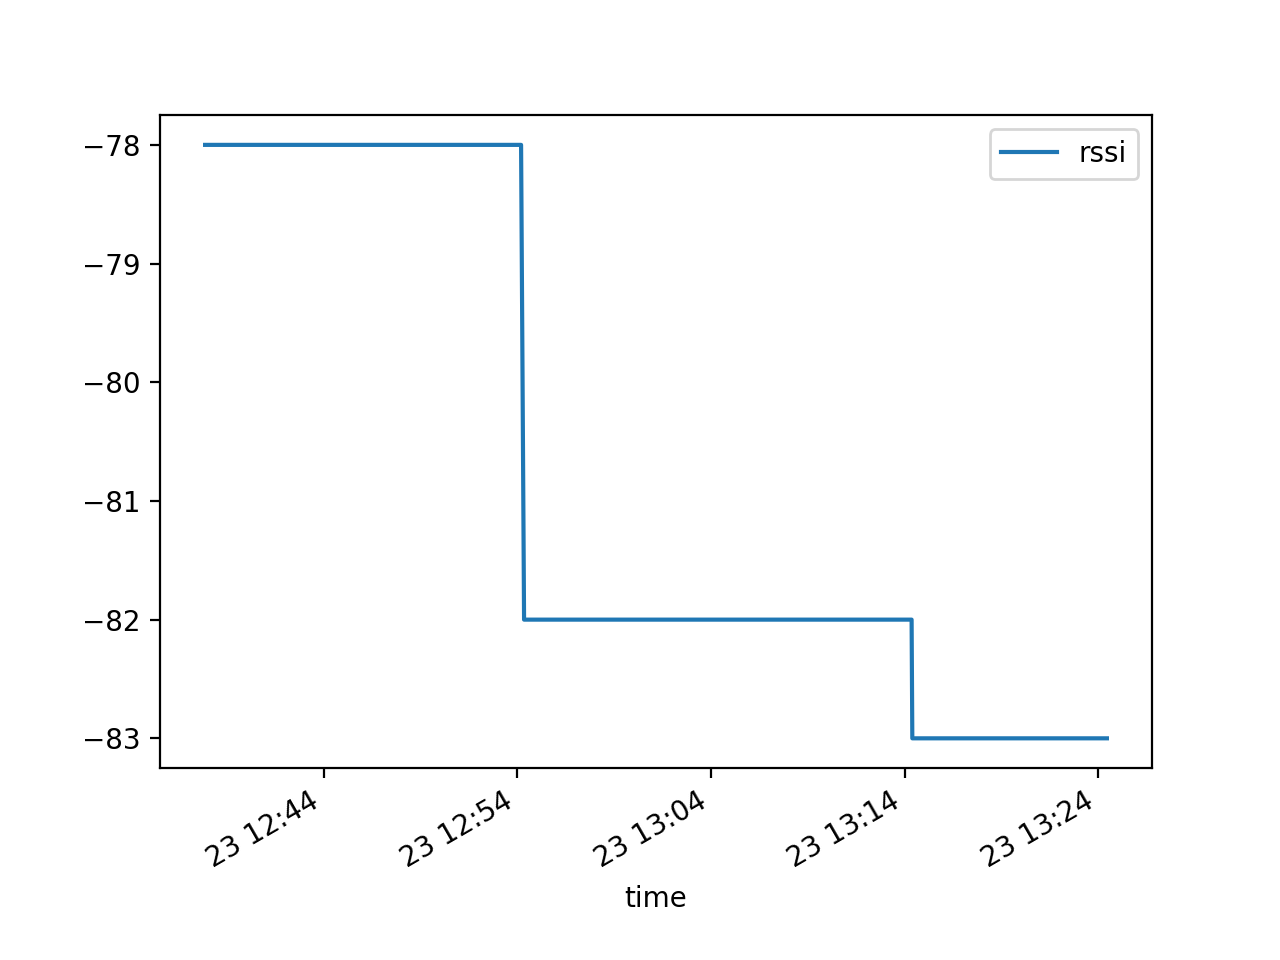

In [265]:
df.query("source == 'basement_pi' and device == 'david phone' and tag == 'upstairs-morning'").set_index('time').plot()

In [249]:
rolling_rssi = df.set_index('time').groupby(['device', 'source']).rolling("3min", min_periods=10)['rssi'].mean().reset_index()
#rolling_rssi = rolling_rssi.set_index('time').groupby(['device', 'source']).rolling("5min", min_periods=5)['rssi'].mean().reset_index()
rolling_labeled = pd.merge(df.drop('rssi', axis=1), rolling_rssi, on=['device', 'source', 'time']).dropna()
rolling_labeled

,time,device,source,tag,rssi
49,2022-10-22 23:45:43.308412+00:00,david phone,living_room_blinds,main-floor-dnd,-61.800000
52,2022-10-22 23:45:45.180944+00:00,david phone,living_room_blinds,main-floor-dnd,-61.545455
57,2022-10-22 23:45:47.144420+00:00,david phone,living_room_blinds,main-floor-dnd,-61.333333
60,2022-10-22 23:45:47.521764+00:00,aysylu phone,bedroom_blinds,main-floor-dnd,-80.000000
62,2022-10-22 23:45:47.822308+00:00,aysylu phone,bedroom_blinds,main-floor-dnd,-80.181818
...,...,...,...,...,...
12088,2022-10-24 22:06:15.923600+00:00,david watch,living_room_blinds,basement-david-only,-75.810811
12089,2022-10-24 22:06:16.219159+00:00,david watch,bedroom_blinds,basement-david-only,-79.363636
12090,2022-10-24 22:06:17.668692+00:00,david phone,basement_pi,basement-david-only,-81.000000
12091,2022-10-24 22:06:18.167759+00:00,david watch,bedroom_blinds,basement-david-only,-79.352941


In [250]:
with_station = rolling_labeled
for station in base_station_names:
    specific_station = rolling_labeled.query(f"source == '{station}'").copy()
    specific_station = specific_station.drop('source',axis=1).rename(columns={'rssi': station})
    with_station = pd.merge_asof(with_station, specific_station,
                                 left_on='time',
                                 right_on='time',
                                 direction='backward',
                                 allow_exact_matches=False,
                                 tolerance=pd.Timedelta(seconds=5),
                                 by=['device', 'tag'])
for station in base_station_names:
    with_station[station] = np.where(with_station['source'] == station, with_station['rssi'], with_station[station])
with_station = with_station.drop(['source', 'rssi'], axis=1).dropna()#.fillna(-100)
# TODO should this be dropna or fillna?
with_station

,time,device,tag,living_room_blinds,bedroom_blinds,basement_pi
89,2022-10-22 23:46:46.744195+00:00,aysylu phone,main-floor-dnd,-76.555556,-80.071429,-73.0
94,2022-10-22 23:46:48.636122+00:00,aysylu phone,main-floor-dnd,-76.555556,-79.965517,-73.0
96,2022-10-22 23:46:49.202744+00:00,aysylu phone,main-floor-dnd,-76.321429,-79.965517,-73.0
97,2022-10-22 23:46:49.289956+00:00,aysylu phone,main-floor-dnd,-76.321429,-80.366667,-73.0
99,2022-10-22 23:46:50.479551+00:00,aysylu phone,main-floor-dnd,-76.137931,-80.366667,-73.0
...,...,...,...,...,...,...
11728,2022-10-24 22:05:36.897853+00:00,david watch,basement-david-only,-75.722222,-78.636364,-77.0
11735,2022-10-24 22:05:44.717100+00:00,david phone,basement-david-only,-84.481481,-89.863636,-81.0
11738,2022-10-24 22:05:46.771024+00:00,david watch,basement-david-only,-75.710526,-78.900000,-77.0
11747,2022-10-24 22:06:00.485542+00:00,david watch,basement-david-only,-75.894737,-79.033333,-77.0


In [171]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(with_station[base_station_names], with_station['tag'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [172]:
knn.predict([[-70,-70], [-81, -81], [-66,-77]])

array(['upstairs', 'upstairs', 'main_floor'], dtype=object)

<IPython.core.display.Javascript object>


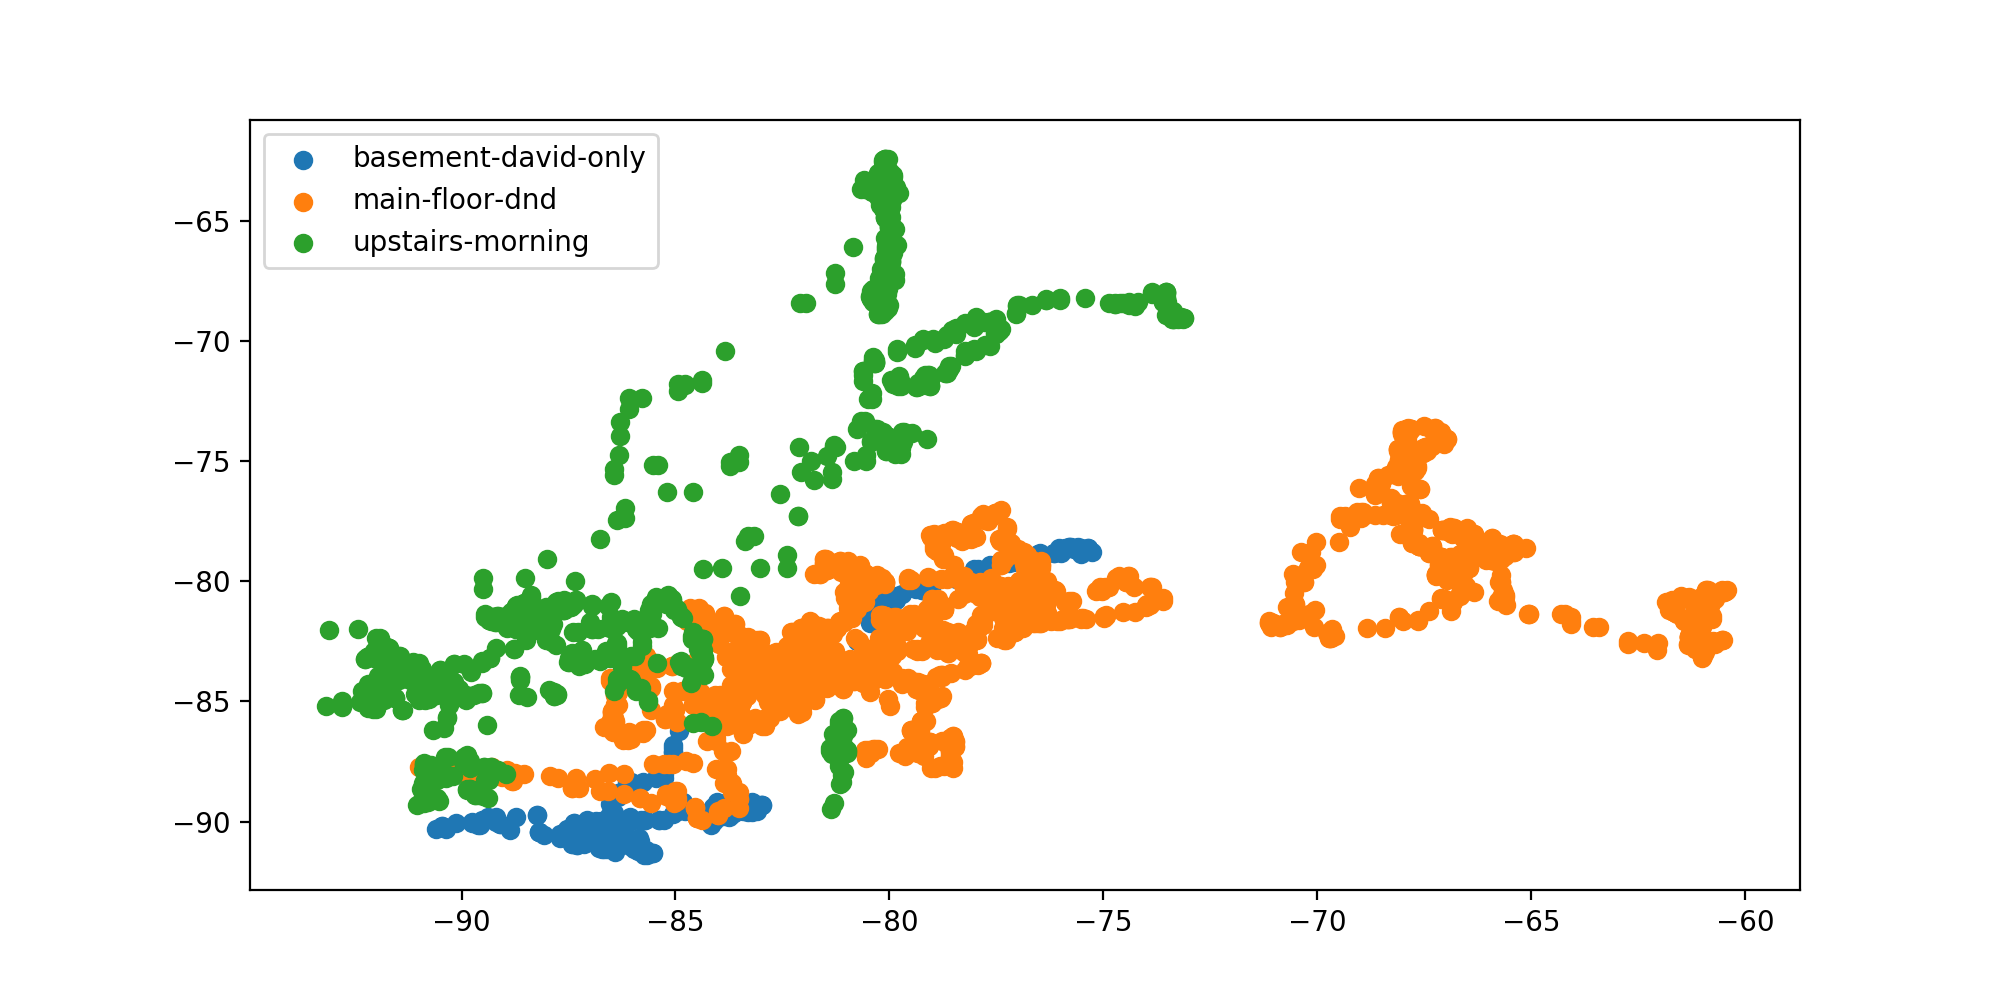

basement-david-only
main-floor-dnd
upstairs-morning


In [244]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5)) # set the size of the figure
for floor in [
    'basement-david-only',
    'main-floor-dnd',
    'upstairs-morning',
]:#list(np.unique(with_station['tag'])):
    q= with_station.query(f"tag == '{floor}'")# and tag != 'main-floor-dnd'")
    print(floor)
    plt.scatter(q['living_room_blinds'], q['bedroom_blinds'], label=floor) # scatter plot of the data
plt.legend(loc='upper left')


<IPython.core.display.Javascript object>


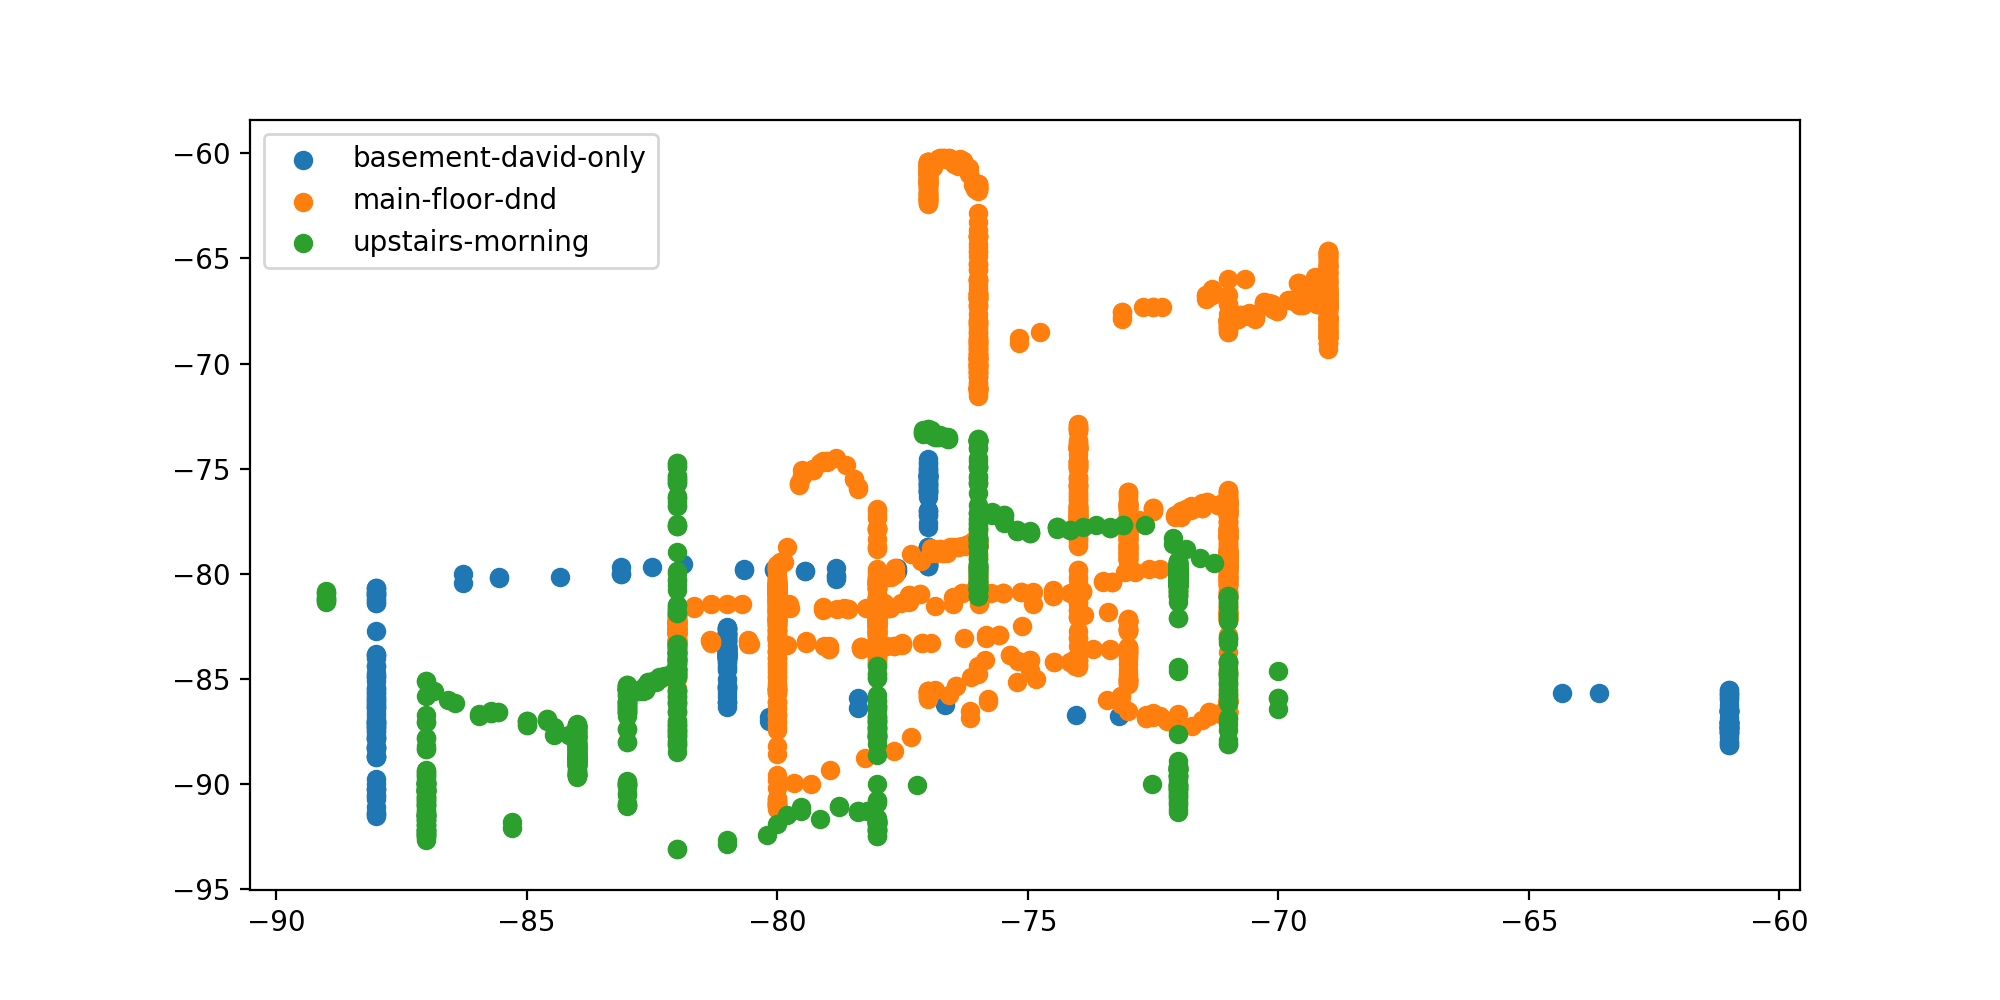

basement-david-only
main-floor-dnd
upstairs-morning


In [224]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5)) # set the size of the figure
for floor in list(np.unique(with_station['tag'])):
    q= with_station.query(f"tag == '{floor}'")# and tag != 'main-floor-dnd'")
    print(floor)
    plt.scatter(q['basement_pi'], q['living_room_blinds'], label=floor) # scatter plot of the data
plt.legend(loc='upper left')



<IPython.core.display.Javascript object>


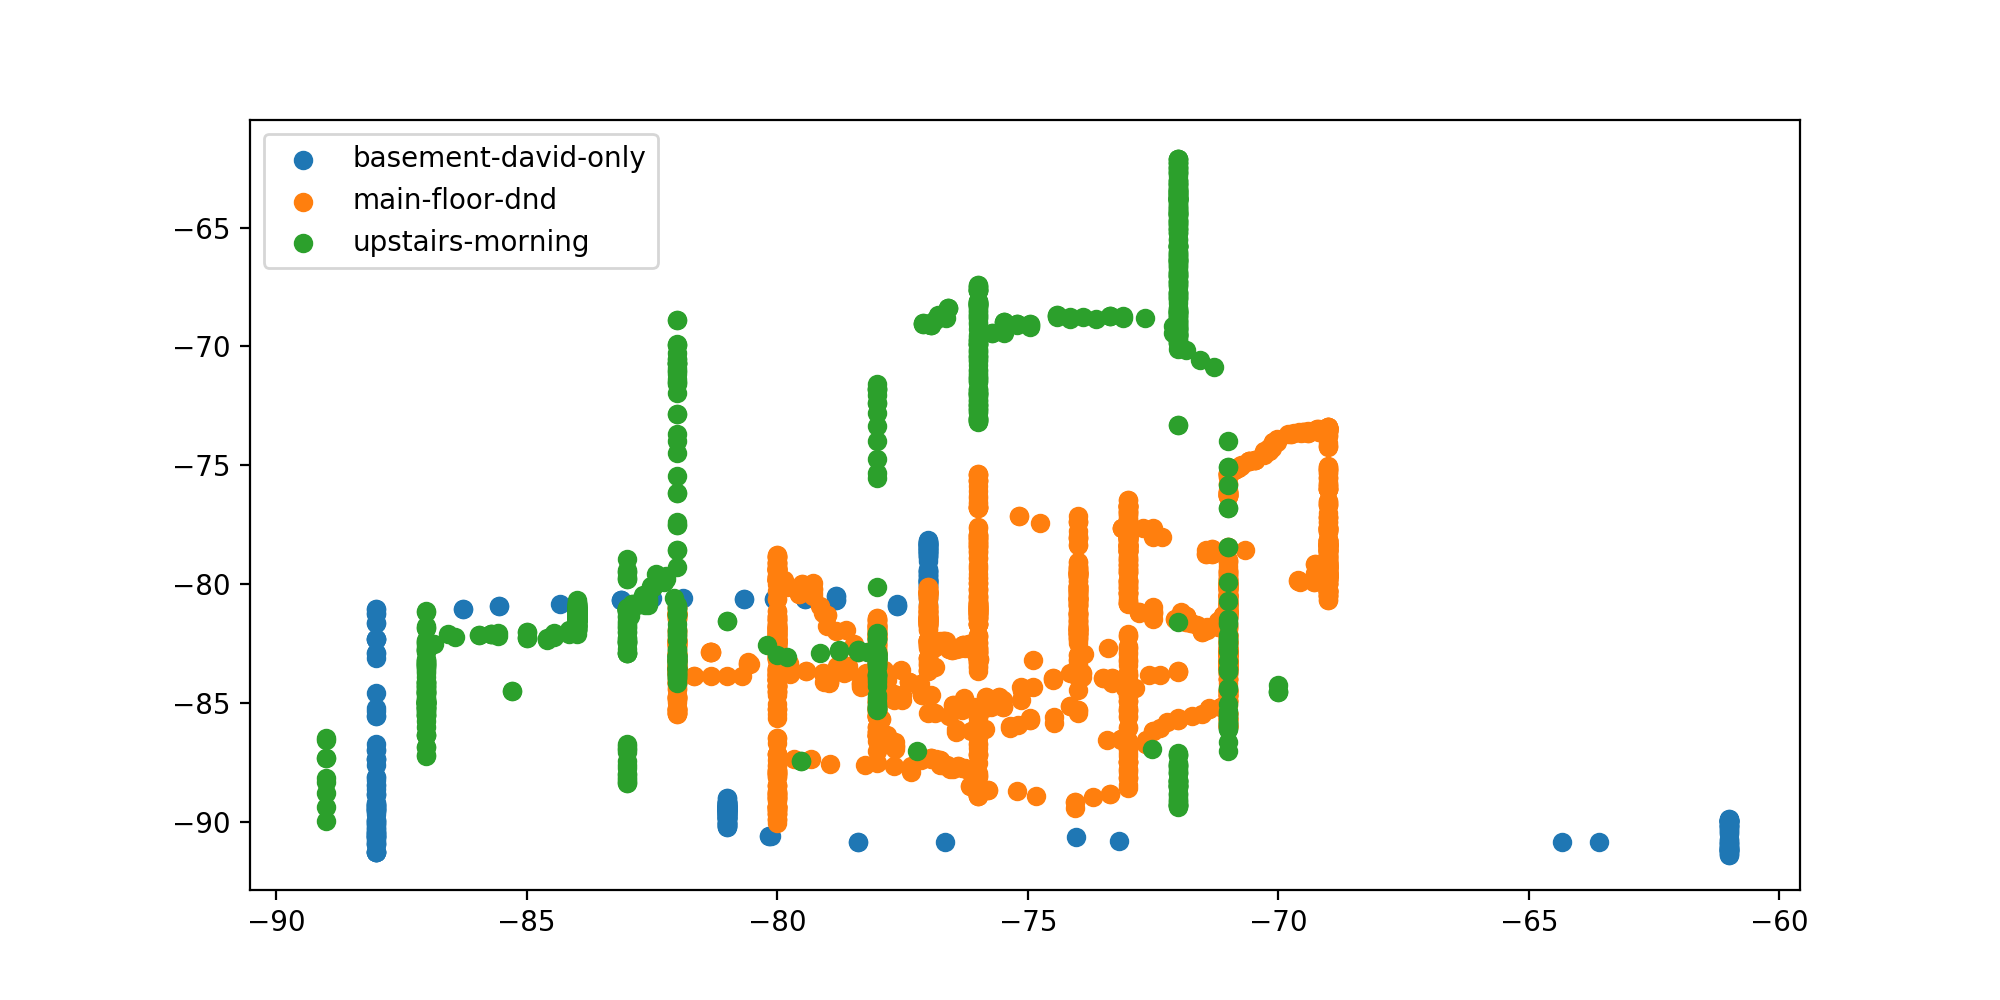

basement-david-only
main-floor-dnd
upstairs-morning


In [266]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5)) # set the size of the figure
for floor in list(np.unique(with_station['tag'])):
    q= with_station.query(f"tag == '{floor}'")# and tag != 'main-floor-dnd'")
    print(floor)
    plt.scatter(q['basement_pi'], q['bedroom_blinds'], label=floor) # scatter plot of the data
plt.legend(loc='upper left')




In [210]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


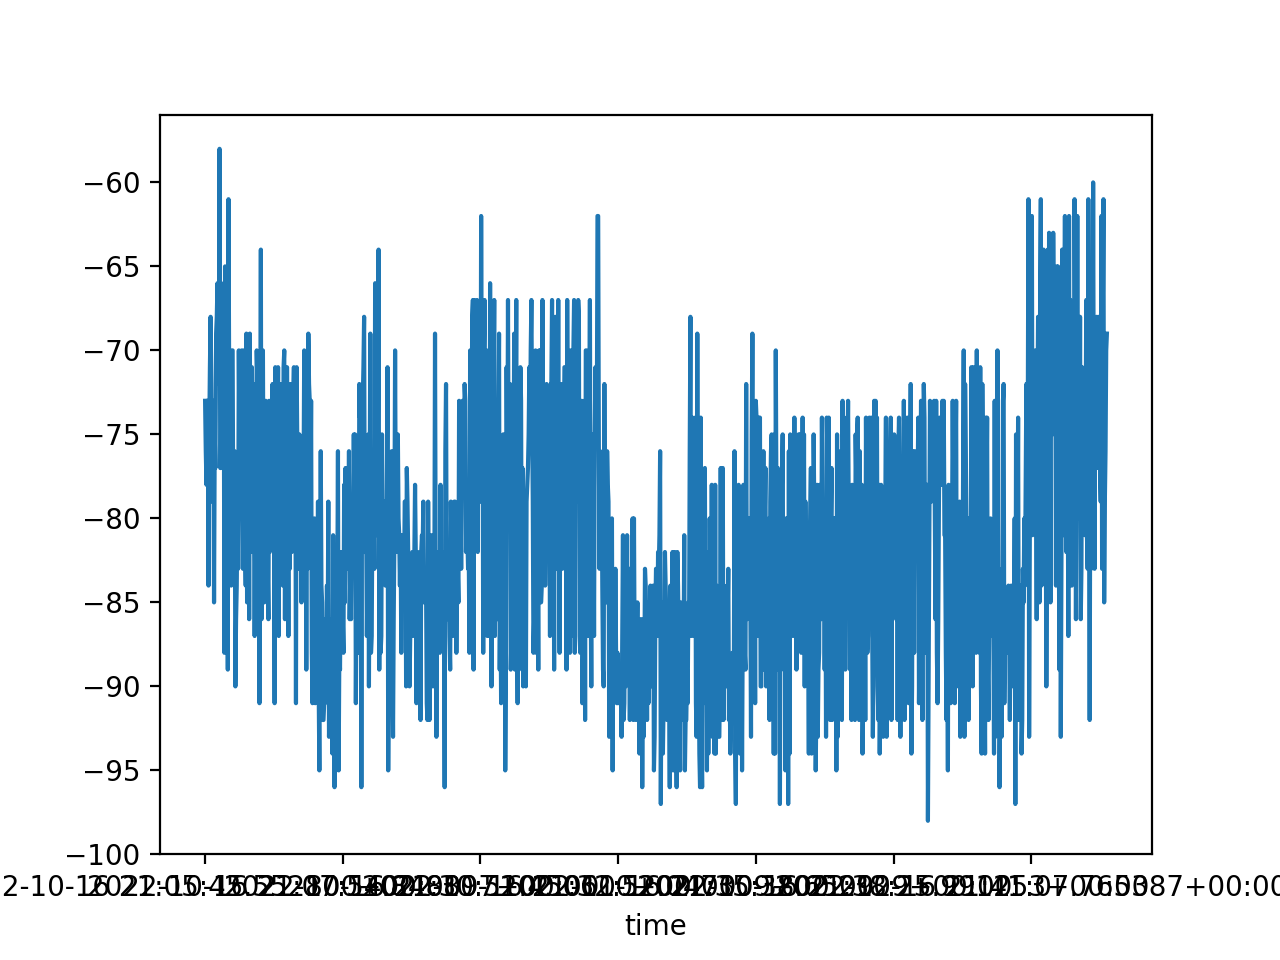

In [117]:
df.set_index('time')['rssi'].plot()

In [100]:
from dateutil.parser import parse
parse('2022-10-16T18:26:37.868194+00:00')

datetime.datetime(2022, 10, 16, 18, 26, 37, 868194, tzinfo=tzutc())